In [1]:
import ephem
import numpy as np
import time
import sys
import re


from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u

from matplotlib import pylab as plt

In [2]:
print np.genfromtxt("/Users/Miau/Dropbox/0_NH_Research/60cm/soft/version02/pointing/p_parameters.txt")


[ 656.82 -552.25  339.64  -33.99  -45.7    90.22  270.32  195.83  -52.92
 -477.22  364.68  178.19 -316.02   23.49]


In [3]:


file1 = "20130202.txt"
file2 = "20130921.txt"

def name_to_time(file1):
    time = file1[:4]+"-"+file1[4:6]+"-"+file1[6:8]
    return time 

def readtxt(fname):
    with open(fname) as f:
        content = f.read().splitlines()
        a = []
        for i in content:
            a.append(i.split())
        
    return [a[0],np.asarray(a[1:]).astype("float")]


def get_groups(data1):    
    obj1RA = data1[:,:3]
    obj1DC = data1[:,3:6]
    tel1RA = data1[:,6:9]
    tel1DC = data1[:,9:12]
    time1  = data1[:,12:]
    return obj1RA,obj1DC,tel1RA,tel1DC,time1

def to_string(data): ### convert coordinate arrays to string
    string = []
    for i in data:
        if i.shape[0] == 3:
            string.append(str(int(i[0]))+":"+str(int(i[1]))+":"+str(i[2]))
        else:
            string.append(str(int(i[0]))+":"+str(int(i[1])))
    return string

def time_string(data):
    string = []
    for i in data:
        string.append(str(int(i[0]))+":"+str(int(i[1])))
    return string


def get_coord(RA, DEC):
    
    COORD = []
    for i in range(RA.shape[0]):
        C = SkyCoord(RA[i]+" "+DEC[i],unit=(u.hourangle, u.deg))
        COORD.append([C.ra.deg,C.dec.deg])
    return np.asarray(COORD)
        
#def str_2_coord_List(RA, DEC, time, file1):
#    site = ephem.Observer()
#    site.lon       = '134:20:08'
#    site.lat       = '35:01:32'
#    site.elevation = 449
#    for i in range(RA.shape[0]):
#            site.date      = ephem.Date(file1[:4]+"/"+file1[4:6]+"/"+file1[6:8]+" "+time[i])
#            target         = ephem.FixedBody()
#            target._ra     = "20:41:25.92"
#            target._dec    = "+45:16:49.3"
#            target.compute(site)
#return 
    

In [5]:
content0 = readtxt(file1)
floatsar = get_groups(content0[1])
RA   = np.asarray(to_string(floatsar[0]))
DEC  = np.asarray(to_string(floatsar[1]))
dRA  = np.asarray(to_string(floatsar[2]))
dDEC = np.asarray(to_string(floatsar[3]))

PHI  = np.chararray(RA.shape, itemsize=9)
PHI[:]  = "+35:01:32.0"
PHI  = np.asarray(PHI)
TIME = np.asarray(to_string(floatsar[4]))

RADEC  = get_coord(RA  ,DEC)
dRADEC = get_coord(dRA ,dDEC)
TIMEPHI= get_coord(TIME, PHI)
phi    = TIMEPHI[0,1].copy()
TIMEPHI[:,1] = 0

In [6]:
RADEC  = RADEC  - TIMEPHI
dRADEC = dRADEC - TIMEPHI

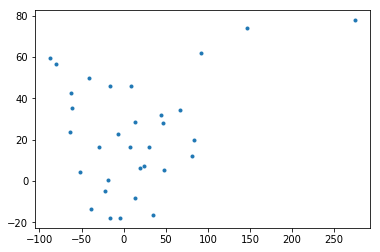

In [7]:
plt.plot(RADEC[:,0],RADEC[:,1], ".")
plt.show()

In [8]:
#### el < 90, -90 <= az <= 90
def rotation_limit(data):
    for i in range(data.shape[0]):
        if data[i,0] > 180.:
            data[i,0] = data[i,0]-360.
        elif data[i,0] < -180.:
            data[i,0] = data[i,0]+360.
        else:
            pass
        
        if data[i,0] > 90.:
            data[i,0] = data[i,0]-180.
            data[i,1] = data[i,1]+2*(90.-data[i,1])
        else:
            pass
        if data[i,0] < -90.:
            data[i,0] = data[i,0]+180.
            data[i,1] = data[i,1]+2*(90.-data[i,1])
        else:
            pass
    return data
radec  = rotation_limit(RADEC)
dradec = rotation_limit(dRADEC)

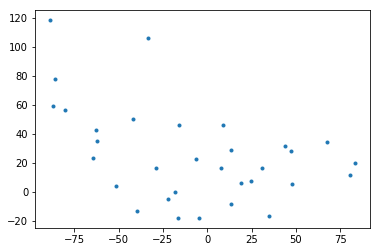

In [9]:
plt.plot(radec[:,0],radec[:,1], ".")
plt.show()

## Tpoint parameters

In [10]:
panam = np.asarray(["IH" ,
                    "ID" ,
                    "NP",
                    "CH",
                    "ME",
                    "MA",
                    "FO",
                    "DAF",
                    "HCES",
                    "HCEC",
                    "DCES",
                    "DCEC",
                    "DNP",
                    "TF",
                    "TX"])

In [11]:
param = np.asarray([ 656.82 , 
             -552.25, 
              339.64, 
              -33.99, 
              -45.70,
               90.22, 
              270.32, 
              195.83, 
              -52.92, 
             -477.22, 
              364.68, 
              178.19, 
             -316.02,
               23.49,
             -178.90])


$dRa  = P \times V_{RA}(Ra, Dec, phi)$ 

$dDEC = P \times V_{DEC}(Ra, Dec, phi)$


In [12]:
def compute_off(RA, DEC,  PHI):
    ra, dec, phi = np.asarray([RA, DEC, PHI])*np.pi/180.
    param = np.asarray([ 656.82 ,  #IH
                         -552.25,  #ID
                          339.64,  #NP
                          -33.99,  #CH
                          -45.70,  #ME
                           90.22,  #MA
                          270.32,  #F0
                          195.83,  #DAF
                          -52.92,  #HCES
                         -477.22,  #HCEC
                          364.68,  #DCES
                          178.19,  #DCEC
                         -316.02,  #DNP
                           23.49])  #TF
                         #-178.90]) #TX
    
    raC = np.asarray([  1.0,                      ##IH
                        0.0, 
                        np.tan(dec),              ##NP
                        1./np.cos(dec),           ##CH
                        np.sin(ra) * np.tan(dec) ,##ME
                        (-1.)*np.cos(ra) * np.tan(dec), ##MA
                        0.0, 
                        (-1.)*(np.cos(phi)*np.cos(ra) + np.sin(phi)*np.tan(dec) ),##FDAF
                        np.sin(ra),                  ##HCES
                        np.cos(ra), ##HCEC
                        0.0, 
                        0.0, 
                        np.sin(ra) * np.tan(dec), ##DNP
                        np.cos(phi) * np.sin(ra) / np.cos(dec)])#, ##TF
                        #0.0])
                        
    deC = np.asarray(  [0.0,
                        1.0, ##ID
                        0.0,
                        0.0,
                        np.cos(ra), ##ME
                        np.sin(ra),  ##MA
                        np.cos(ra),  ##FO
                        0.0,
                        0.0,
                        0.0,
                        np.sin(dec), ##DCES
                        np.cos(dec), ##DCEC
                        0.0,
                        np.cos(phi)*np.cos(ra)*np.sin(dec) - np.sin(phi)*np.cos(dec)])#, ##TF
                        #0.0])
    
    return np.sum(raC*param/3600.), np.sum(deC*param/3600.)
    
    
Coffset = compute_off(radec[0,0],radec[0,1], phi)

## Vectorize that shit!

In [13]:
def compute_off(RA, DEC,  PHI):
    ra, dec, phi = np.asarray([RA, DEC, PHI])*np.pi/180.
    s = ra.shape
    param = np.asarray([ 656.82 ,  #IH
                         -552.25,  #ID
                          339.64,  #NP
                          -33.99,  #CH
                          -45.70,  #ME
                           90.22,  #MA
                          270.32,  #F0
                          195.83,  #DAF
                          -52.92,  #HCES
                         -477.22,  #HCEC
                          364.68,  #DCES
                          178.19,  #DCEC
                         -316.02,  #DNP
                           23.49])  #TF
                         #-178.90]) #TX
    
    raC = np.asarray([  np.ones(s),                      ##IH
                        np.zeros(s), 
                        np.tan(dec),              ##NP
                        1./np.cos(dec),           ##CH
                        np.sin(ra) * np.tan(dec) ,##ME
                        (-1.)*np.cos(ra) * np.tan(dec), ##MA
                        np.zeros(s), 
                        (-1.)*(np.cos(phi)*np.cos(ra) + np.sin(phi)*np.tan(dec) ),##FDAF
                        np.sin(ra),                  ##HCES
                        np.cos(ra), ##HCEC
                        np.zeros(s), 
                        np.zeros(s), 
                        np.sin(ra) * np.tan(dec), ##DNP
                        np.cos(phi) * np.sin(ra) / np.cos(dec)])#, ##TF
                        #np.zeros(s)])
                        
    deC = np.asarray(  [np.zeros(s),
                        np.ones(s), ##ID
                        np.zeros(s),
                        np.zeros(s),
                        np.cos(ra), ##ME
                        np.sin(ra),  ##MA
                        np.cos(ra),  ##FO
                        np.zeros(s),
                        np.zeros(s),
                        np.zeros(s),
                        np.sin(dec), ##DCES
                        np.cos(dec), ##DCEC
                        np.zeros(s),
                        np.cos(phi)*np.cos(ra)*np.sin(dec) - np.sin(phi)*np.cos(dec)])#, ##TF
                        #np.zeros(s)])
    
    return np.asarray([np.sum(raC.T*param/3600.,1), np.sum(deC.T*param/3600., 1)]).T
    
    
Coffset = compute_off(radec[:,0],radec[:,1], phi)

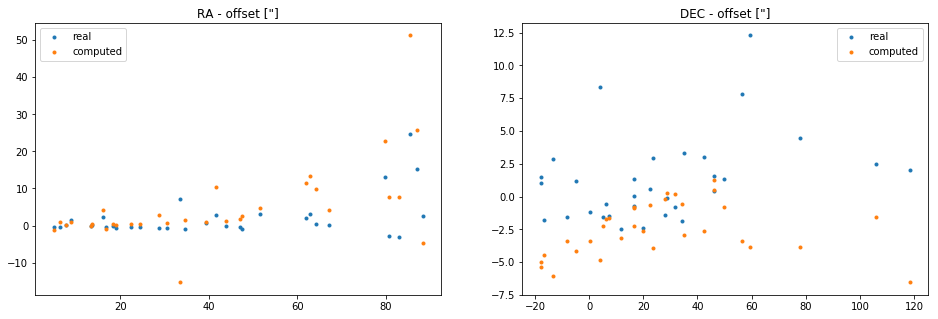

In [14]:
Doffset = radec - dradec

fig = plt.figure(figsize=(16,5))
ax1  = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(np.abs(radec[:,0]),Doffset[:,0]*60.,".", label = "real")
ax1.plot(np.abs(radec[:,0]),Coffset[:,0]*60.,".", label = "computed")
ax1.legend()
ax1.set_title("RA - offset [\"]")


ax2.plot((radec[:,1]),Doffset[:,1]*60.,".", label = "real")
ax2.plot((radec[:,1]),Coffset[:,1]*60.,".", label = "computed")
ax2.legend()
ax2.set_title("DEC - offset [\"]")
plt.show()

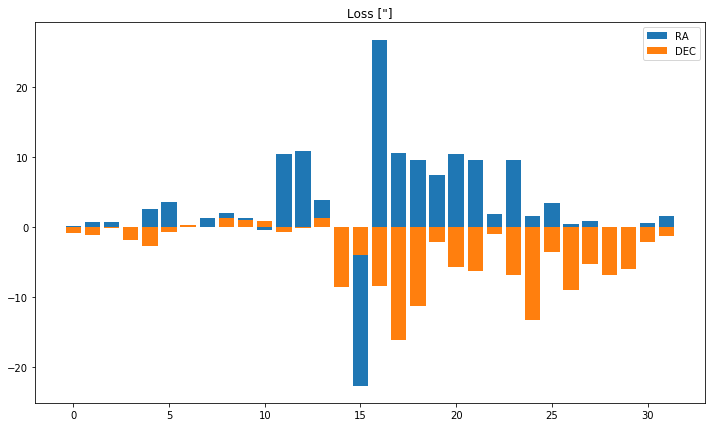

In [15]:
loss = Coffset-Doffset
fig = plt.figure(figsize=(12,7))
plt.bar(range(radec.shape[0]),loss[:,0]*60.,label = "RA")
plt.bar(range(radec.shape[0]),loss[:,1]*60.,label = "DEC")
plt.legend()
plt.title("Loss [\"]")
plt.show()

In [16]:
a = np.random.rand(5,5)
x = np.random.rand(5)

In [17]:
c = np.matmul(a,x)
print c.shape

(5,)


In [18]:
X = np.linalg.solve(a,c)

In [19]:
print x.shape
#print X.shape
print X
print x

(5,)
[ 0.04009693  0.36814628  0.73446011  0.12331719  0.81790921]
[ 0.04009693  0.36814628  0.73446011  0.12331719  0.81790921]


In [20]:
w = np.asarray([ 656.82 ,  #IH
                     -552.25,  #ID
                      339.64,  #NP
                      -33.99,  #CH
                      -45.70,  #ME
                       90.22,  #MA
                      270.32,  #F0
                      195.83,  #DAF
                      -52.92,  #HCES
                     -477.22,  #HCEC
                      364.68,  #DCES
                      178.19,  #DCEC
                     -316.02,  #DNP
                       23.49])  #TF
                     #-178.90]) #TX

In [21]:
def compute_hidden(RA, DEC,  PHI):
    
    ra, dec, phi = np.asarray([RA, DEC, PHI])*np.pi/180.
    s = ra.shape
    
    raC = np.asarray([  np.ones(s),                      ##IH
                        np.zeros(s), 
                        np.tan(dec),              ##NP
                        1./np.cos(dec),           ##CH
                        np.sin(ra) * np.tan(dec) ,##ME
                        (-1.)*np.cos(ra) * np.tan(dec), ##MA
                        np.zeros(s), 
                        (-1.)*(np.cos(phi)*np.cos(ra) + np.sin(phi)*np.tan(dec) ),##FDAF
                        np.sin(ra),                  ##HCES
                        np.cos(ra), ##HCEC
                        np.zeros(s), 
                        np.zeros(s), 
                        np.sin(ra) * np.tan(dec), ##DNP
                        np.cos(phi) * np.sin(ra) / np.cos(dec)])#, ##TF
                        #np.zeros(s)])
                        
    deC = np.asarray(  [np.zeros(s),
                        np.ones(s), ##ID
                        np.zeros(s),
                        np.zeros(s),
                        np.cos(ra), ##ME
                        np.sin(ra),  ##MA
                        np.cos(ra),  ##FO
                        np.zeros(s),
                        np.zeros(s),
                        np.zeros(s),
                        np.sin(dec), ##DCES
                        np.cos(dec), ##DCEC
                        np.zeros(s),
                        np.cos(phi)*np.cos(ra)*np.sin(dec) - np.sin(phi)*np.cos(dec)])#, ##TF
                        #np.zeros(s)])
    
    return np.asarray([raC, deC])
    
hidden = compute_hidden(radec[:,0],radec[:,1], phi*np.ones(radec.shape[0]))

In [22]:
print hidden.shape
print w.shape
print Doffset.T.shape

(2, 14, 32)
(14,)
(2, 32)


In [23]:
np.linalg.solve(hidden[:,:,:14],c)

ValueError: solve: Input operand 1 does not have enough dimensions (has 1, gufunc core with signature (m,m),(m,n)->(m,n) requires 2)

In [24]:
import torch
from torch.autograd import Variable

In [25]:
torch.cuda.is_available()

True

In [26]:
np.linalg.solve(np.asarray([[1.,2.],[1.,3.]]),np.asarray([10.,20.]))

array([-10.,  10.])

In [27]:
dtype = torch.FloatTensor
X = Variable(torch.FloatTensor([[1.,2.],[1.,3.]]), requires_grad=False)
Y = Variable(torch.FloatTensor([10.,20.])      , requires_grad=False)
W = Variable(torch.randn(2).type(dtype), requires_grad=True)

In [28]:
LOSS  = []
weight= []
dweight= []

In [29]:
learning_rate = 0.05
for i in range(1000):
    
    yp   = torch.matmul(X,W)
    loss = (yp - Y).pow(2).sum()
    LOSS.append(loss.data[0])
    loss.backward()
    dweight.append(W.grad.data.numpy().copy())
    weight.append(W.data.numpy().copy())
    W.data -=learning_rate * W.grad.data
    
    W.grad.data.zero_()
    
weight  = np.asarray(weight)
dweight = np.asarray(dweight)

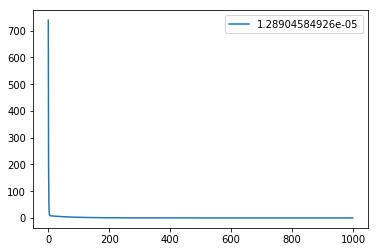

In [30]:
plt.plot(LOSS, label = str(LOSS[-1]))
plt.legend()
plt.show()

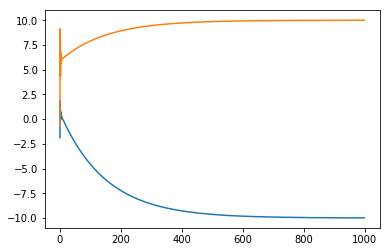

In [31]:
plt.plot(weight[:,0],"-")
plt.plot(weight[:,1],"-")
plt.show()

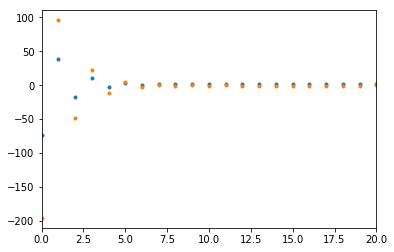

In [32]:
plt.plot(dweight[:,0],".")
plt.plot(dweight[:,1],".")
plt.xlim([0,20])
plt.show()

In [33]:
W

Variable containing:
-9.9871
 9.9950
[torch.FloatTensor of size 2]

In [34]:
(yp - Y).pow(2).sum()

Variable containing:
1.00000e-05 *
  1.2890
[torch.FloatTensor of size 1]

In [35]:
W.detach().numpy()

array([-9.98714733,  9.99503231], dtype=float32)

In [36]:
np.asarray(dweight)

array([[ -7.38934479e+01,  -1.95371445e+02],
       [  3.85709610e+01,   9.55581512e+01],
       [ -1.69223080e+01,  -4.79529266e+01],
       ..., 
       [  1.74903870e-03,  -6.98089600e-04],
       [  1.75285339e-03,  -6.52313232e-04],
       [  1.72233582e-03,  -6.98089600e-04]], dtype=float32)

In [37]:
print hidden.shape
print w.shape
print Doffset.T.shape

(2, 14, 32)
(14,)
(2, 32)


In [38]:
H = np.swapaxes(hidden, 1,2)
W = w
D = np.matmul(H,W)
print H.shape, W.shape, D.shape

(2, 32, 14) (14,) (2, 32)


In [39]:
D.T

array([[   11.72340364,   -50.33081629],
       [   11.45534616,  -104.21155857],
       [   27.73612651,   -97.64976298],
       [  -13.77910073,  -204.23142046],
       [   94.0980237 ,  -267.70477194],
       [  157.94816986,  -135.58419601],
       [   20.92476283,    15.56854653],
       [   45.76585975,   -47.29103553],
       [  108.3667957 ,   -10.30066332],
       [   81.13067274,    11.98837403],
       [   59.09070984,    74.14437808],
       [  456.02268732,  -189.80281934],
       [  460.93821012,  -156.5598706 ],
       [  244.90803841,   -36.11906076],
       [ -284.2549402 ,  -392.64865794],
       [ -919.74670473,   -94.06548351],
       [ 3077.05870152,  -231.8547305 ],
       [ 1553.25289351,  -232.20688769],
       [ 1362.7818229 ,  -203.83498728],
       [  619.02920307,   -48.39069126],
       [  807.20973001,  -156.38937292],
       [  694.70503914,  -176.5269429 ],
       [  251.73815584,    28.72418766],
       [  595.49429665,  -235.92537386],
       [  285.14

In [40]:
def comp_weights(H, D, learning_rate = 0.003, maxdW = 1.):
    
    dtype = torch.FloatTensor
    X = Variable(torch.from_numpy(H).type(dtype), requires_grad=False)
    Y = Variable(torch.from_numpy(D).type(dtype), requires_grad=False)
    W = Variable(torch.randn(X.shape[-1]).type(dtype), requires_grad=True)

    LOSS  = []
    weight= []
    dweight= []
    
    MW = 10.
    
    while MW > maxdW:

        yp   = torch.matmul(X,W)
        loss = (yp - Y).pow(2).sum()
        LOSS.append(loss.data[0])
        loss.backward()
        dweight.append(W.grad.data.numpy().copy())
        weight.append(W.data.numpy().copy())
        W.data -=learning_rate * W.grad.data

        W.grad.data.zero_()

        MW = np.abs(dweight[-1]).max()
        print MW
    weight  = np.asarray(weight)
    dweight = np.asarray(dweight)
    

    
    plt.plot(dW[-100:])
    plt.show()
    
    for i in range(weight.shape[-1]):
        plt.plot(weight[:,1],"-")
    plt.show()
    
    plt.plot(LOSS, label = str(LOSS[-1]))
    plt.legend()
    plt.show()
    
    return weight, dweight
W1, dW = comp_weights(H, D)

60097.0
31664.3
11880.8
7007.65
3836.49
3633.08
3120.51
2776.97
2813.56
2668.56
2607.83
2514.89
2444.6
2372.3
2308.82
2248.51
2193.14
2141.1
2092.41
2046.39
2006.42
1968.09
1930.01
1892.3
1855.04
1818.29
1782.09
1746.49
1711.74
1680.36
1649.8
1620.01
1590.93
1562.54
1534.79
1507.65
1481.11
1455.13
1429.71
1404.81
1380.43
1356.54
1333.14
1310.21
1287.74
1265.72
1244.12
1222.96
1202.21
1181.86
1161.91
1142.35
1123.16
1104.35
1085.89
1067.79
1050.04
1032.62
1015.54
998.776
982.33
966.192
950.362
934.825
919.582
904.62
889.938
875.525
861.386
847.5
833.875
820.497
807.364
794.475
781.816
769.389
757.19
745.208
733.443
721.89
710.546
699.401
688.461
677.713
667.156
656.792
646.603
636.6
626.772
617.115
607.632
598.311
589.151
580.16
571.316
562.632
554.096
545.709
537.459
529.367
521.4
513.577
505.885
498.327
490.895
483.593
476.414
469.359
462.421
455.601
448.896
442.305
435.824
429.45
423.186
417.025
410.971
405.013
399.159
393.396
387.739
382.163
376.69
371.298
366.005
360.793
355.668
35

20.7167
20.6951
20.6746
20.6463
20.6302
20.6086
20.5831
20.5649
20.5378
20.5223
20.4941
20.4793
20.4557
20.4332
20.4086
20.3874
20.3688
20.3451
20.3185
20.3035
20.2761
20.2598
20.2346
20.2176
20.1924
20.1739
20.1533
20.1273
20.1039
20.0913
20.061
20.0391
20.0255
19.9996
19.9817
19.9568
19.9362
19.9169
19.8961
19.8683
19.8497
19.831
19.8065
19.7904
19.77
19.7424
19.725
19.7007
19.684
19.6542
19.6424
19.6181
19.5997
19.5759
19.5557
19.5296
19.5163
19.4897
19.4765
19.4479
19.4336
19.4084
19.385
19.3647
19.346
19.3294
19.3101
19.2822
19.2644
19.2446
19.2198
19.2015
19.1789
19.1667
19.1366
19.1221
19.0998
19.0821
19.057
19.0421
19.0151
18.9984
18.9759
18.9591
18.9348
18.9126
18.9009
18.8663
18.8613
18.8302
18.816
18.793
18.773
18.7535
18.731
18.7181
18.6884
18.6763
18.6536
18.6294
18.6147
18.5958
18.5701
18.5502
18.5341
18.5107
18.49
18.4725
18.4553
18.4332
18.4115
18.3985
18.3708
18.3551
18.3301
18.3202
18.2879
18.2828
18.2474
18.2398
18.2169
18.1919
18.1831
18.1529
18.1395
18.1177
18.0968

4.00441
3.99374
3.99302
3.99032
3.98147
3.97805
3.97407
3.97193
3.96172
3.96
3.96265
3.94751
3.95143
3.94054
3.9429
3.9308
3.93287
3.92615
3.9191
3.92024
3.91443
3.91166
3.9003
3.90295
3.89621
3.89072
3.88675
3.88616
3.88082
3.87283
3.87256
3.86003
3.86707
3.85687
3.85424
3.84814
3.84758
3.84406
3.83602
3.83266
3.82675
3.82704
3.81804
3.81698
3.81037
3.80605
3.80683
3.79679
3.79479
3.79193
3.78338
3.78409
3.77413
3.77591
3.77281
3.76532
3.76165
3.75333
3.75301
3.74638
3.74292
3.74291
3.73998
3.73169
3.7248
3.72596
3.72316
3.71062
3.71339
3.70912
3.70342
3.69845
3.69984
3.68492
3.68947
3.68363
3.68481
3.6718
3.66918
3.66631
3.65955
3.66186
3.65701
3.65176
3.64692
3.64509
3.63901
3.62873
3.63432
3.62661
3.62111
3.6156
3.61585
3.60834
3.60974
3.60016
3.60179
3.59269
3.59435
3.58359
3.58224
3.57941
3.57051
3.57795
3.56345
3.56464
3.56148
3.55315
3.55163
3.54527
3.54628
3.54142
3.53546
3.53705
3.5226
3.52529
3.51708
3.51735
3.51096
3.51476
3.50139
3.50491
3.49681
3.4953
3.49017
3.4876
3.477

NameError: global name 'dW' is not defined

In [ ]:
plt.plot(W1[-1], "o")
plt.plot(W, ".")
plt.show()

In [ ]:
plt.imshow(W1[::1000].T)
plt.show()

## RA/DEC to az,alt

In [ ]:
### Deneb , "20:41:25.92 +45:16:49.3", time: 05:35:30 UTC , azalt: "301:13:04.7 +50:47:25.3"

In [ ]:
deneb = SkyCoord("20:41:25.92 +45:16:49.3" , unit=(u.hourangle, u.deg))
deneb = np.asarray([deneb.ra.deg,deneb.dec.deg])
time  = SkyCoord("01:00:00 +45:16:49.3" , unit=(u.hourangle, u.deg)).ra.deg
def RADEC_ALTAZ(deneb, time, phi = 35.0255555556 ):
    site = ephem.Observer()
    site.lon = '134:20:08'
    site.lat = '35:01:32'
    site.elevation = 449
    target = ephem.FixedBody()
    target._ra = deneb[]
    target._dec = dec_in

In [ ]:
deneb

In [ ]:
site = ephem.Observer()
site.lon       = '134:20:08'
site.lat       = '35:01:32'
site.elevation = 449
site.date      = ephem.Date('2018/02/12 05:35:30.12')
target         = ephem.FixedBody()
target._ra     = "20:41:25.92"
target._dec    = "+45:16:49.3"
target.compute(site)

In [ ]:
print target.ra
print target.dec
print target.az
print target.alt

In [ ]:
site = ephem.Observer()
site.lon       = '134:20:08'
site.lat       = '35:01:32'
site.elevation = 449
site.date      = ephem.Date('2018/02/12 05:35:30.12')
az             = "301:13:04.7" 
el             = "+50:47:25.3"
ra, dec        = site.radec_of(az, el)
print str(ra), str(dec)
target         = SkyCoord(str(ra)+" "+str(dec),unit=(u.hourangle, u.deg))


In [ ]:
target.ra.to_string(u.hourangle, alwayssign=False,sep="")+target.dec.to_string(u.deg, alwayssign=True,sep="")

In [ ]:
target.deg.to_string(u.deg, alwayssign=True,sep="")

In [ ]:
target.split()

In [ ]:
target

In [ ]:
def get_RADEC(az = "301:13:04.7", el = "50:47:25.3", time = '2018/02/12 05:35:30.12', precision =0):
    site = init()
    site.date      = ephem.Date(time)
    ra,dec         = np.asarray(site.radec_of(az, el))
    target         = SkyCoord(ra, dec, unit='rad')
    RA             = target.ra.to_string( u.hourangle,
                                          alwayssign=False,sep="",
                                          precision=precision)
    DEC            = target.dec.to_string(u.deg      ,
                                          alwayssign=True ,
                                          sep="",
                                          precision=precision)
    return RA+DEC
get_RADEC()

In [ ]:
site.sidereal_time()